In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
#rng = np.random.default_rng(seed=42)


In [3]:
df = pd.read_csv('../kruschke_data/Guber1999data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      50 non-null     object 
 1   Spend      50 non-null     float64
 2   StuTeaRat  50 non-null     float64
 3   Salary     50 non-null     float64
 4   PrcntTake  50 non-null     int64  
 5   SATV       50 non-null     int64  
 6   SATM       50 non-null     int64  
 7   SATT       50 non-null     int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [4]:
df.head()

State  Spend  StuTeaRat  Salary  PrcntTake  SATV  SATM  SATT
0     Alabama  4.405       17.2  31.144          8   491   538  1029
1      Alaska  8.963       17.6  47.951         47   445   489   934
2     Arizona  4.778       19.3  32.175         27   448   496   944
3    Arkansas  4.459       17.1  28.934          6   482   523  1005
4  California  4.992       24.0  41.078         45   417   485   902

In [24]:
X = df[["Spend", "PrcntTake"]]
y = df["SATT"]

_, mu_X, sigma_X = bst.standardize(X)
_, mu_y, sigma_y = bst.standardize(y)

In [37]:
mu_X.shape

(2,)

In [7]:
model, idata = bst.multiple_linear_regression(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta, nu_minus_one, nu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


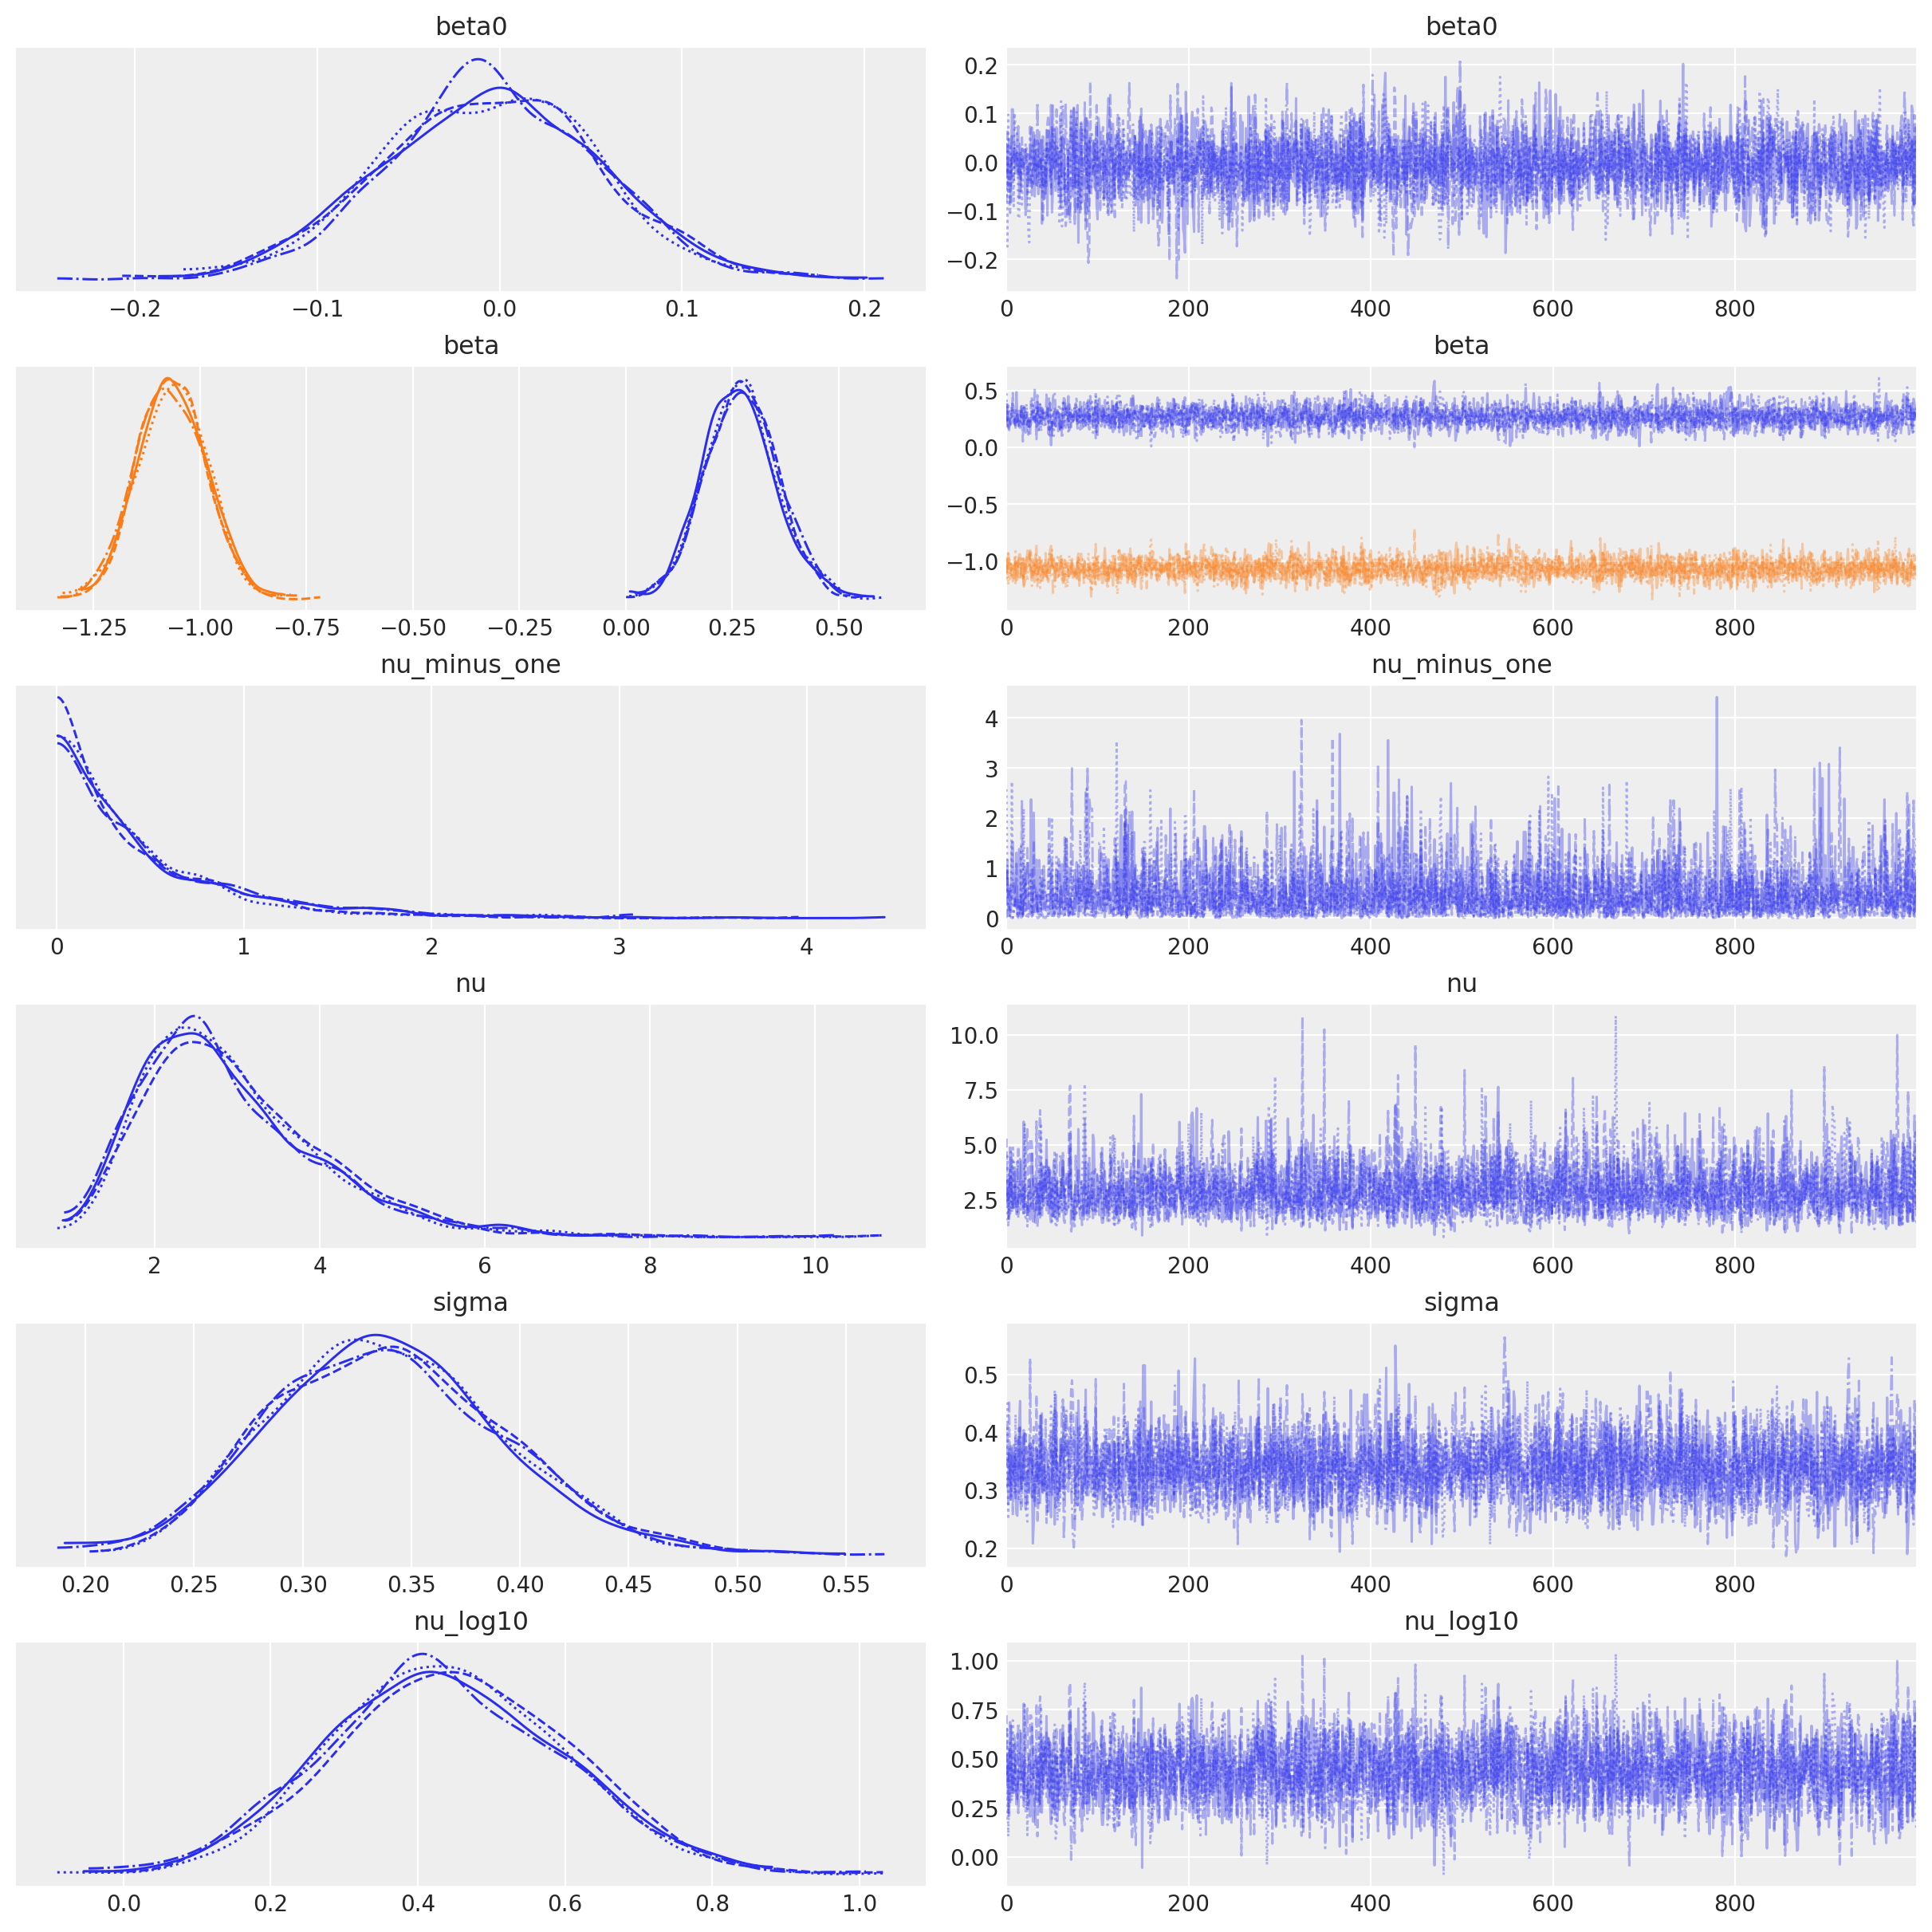

In [8]:
pm.plot_trace(idata);

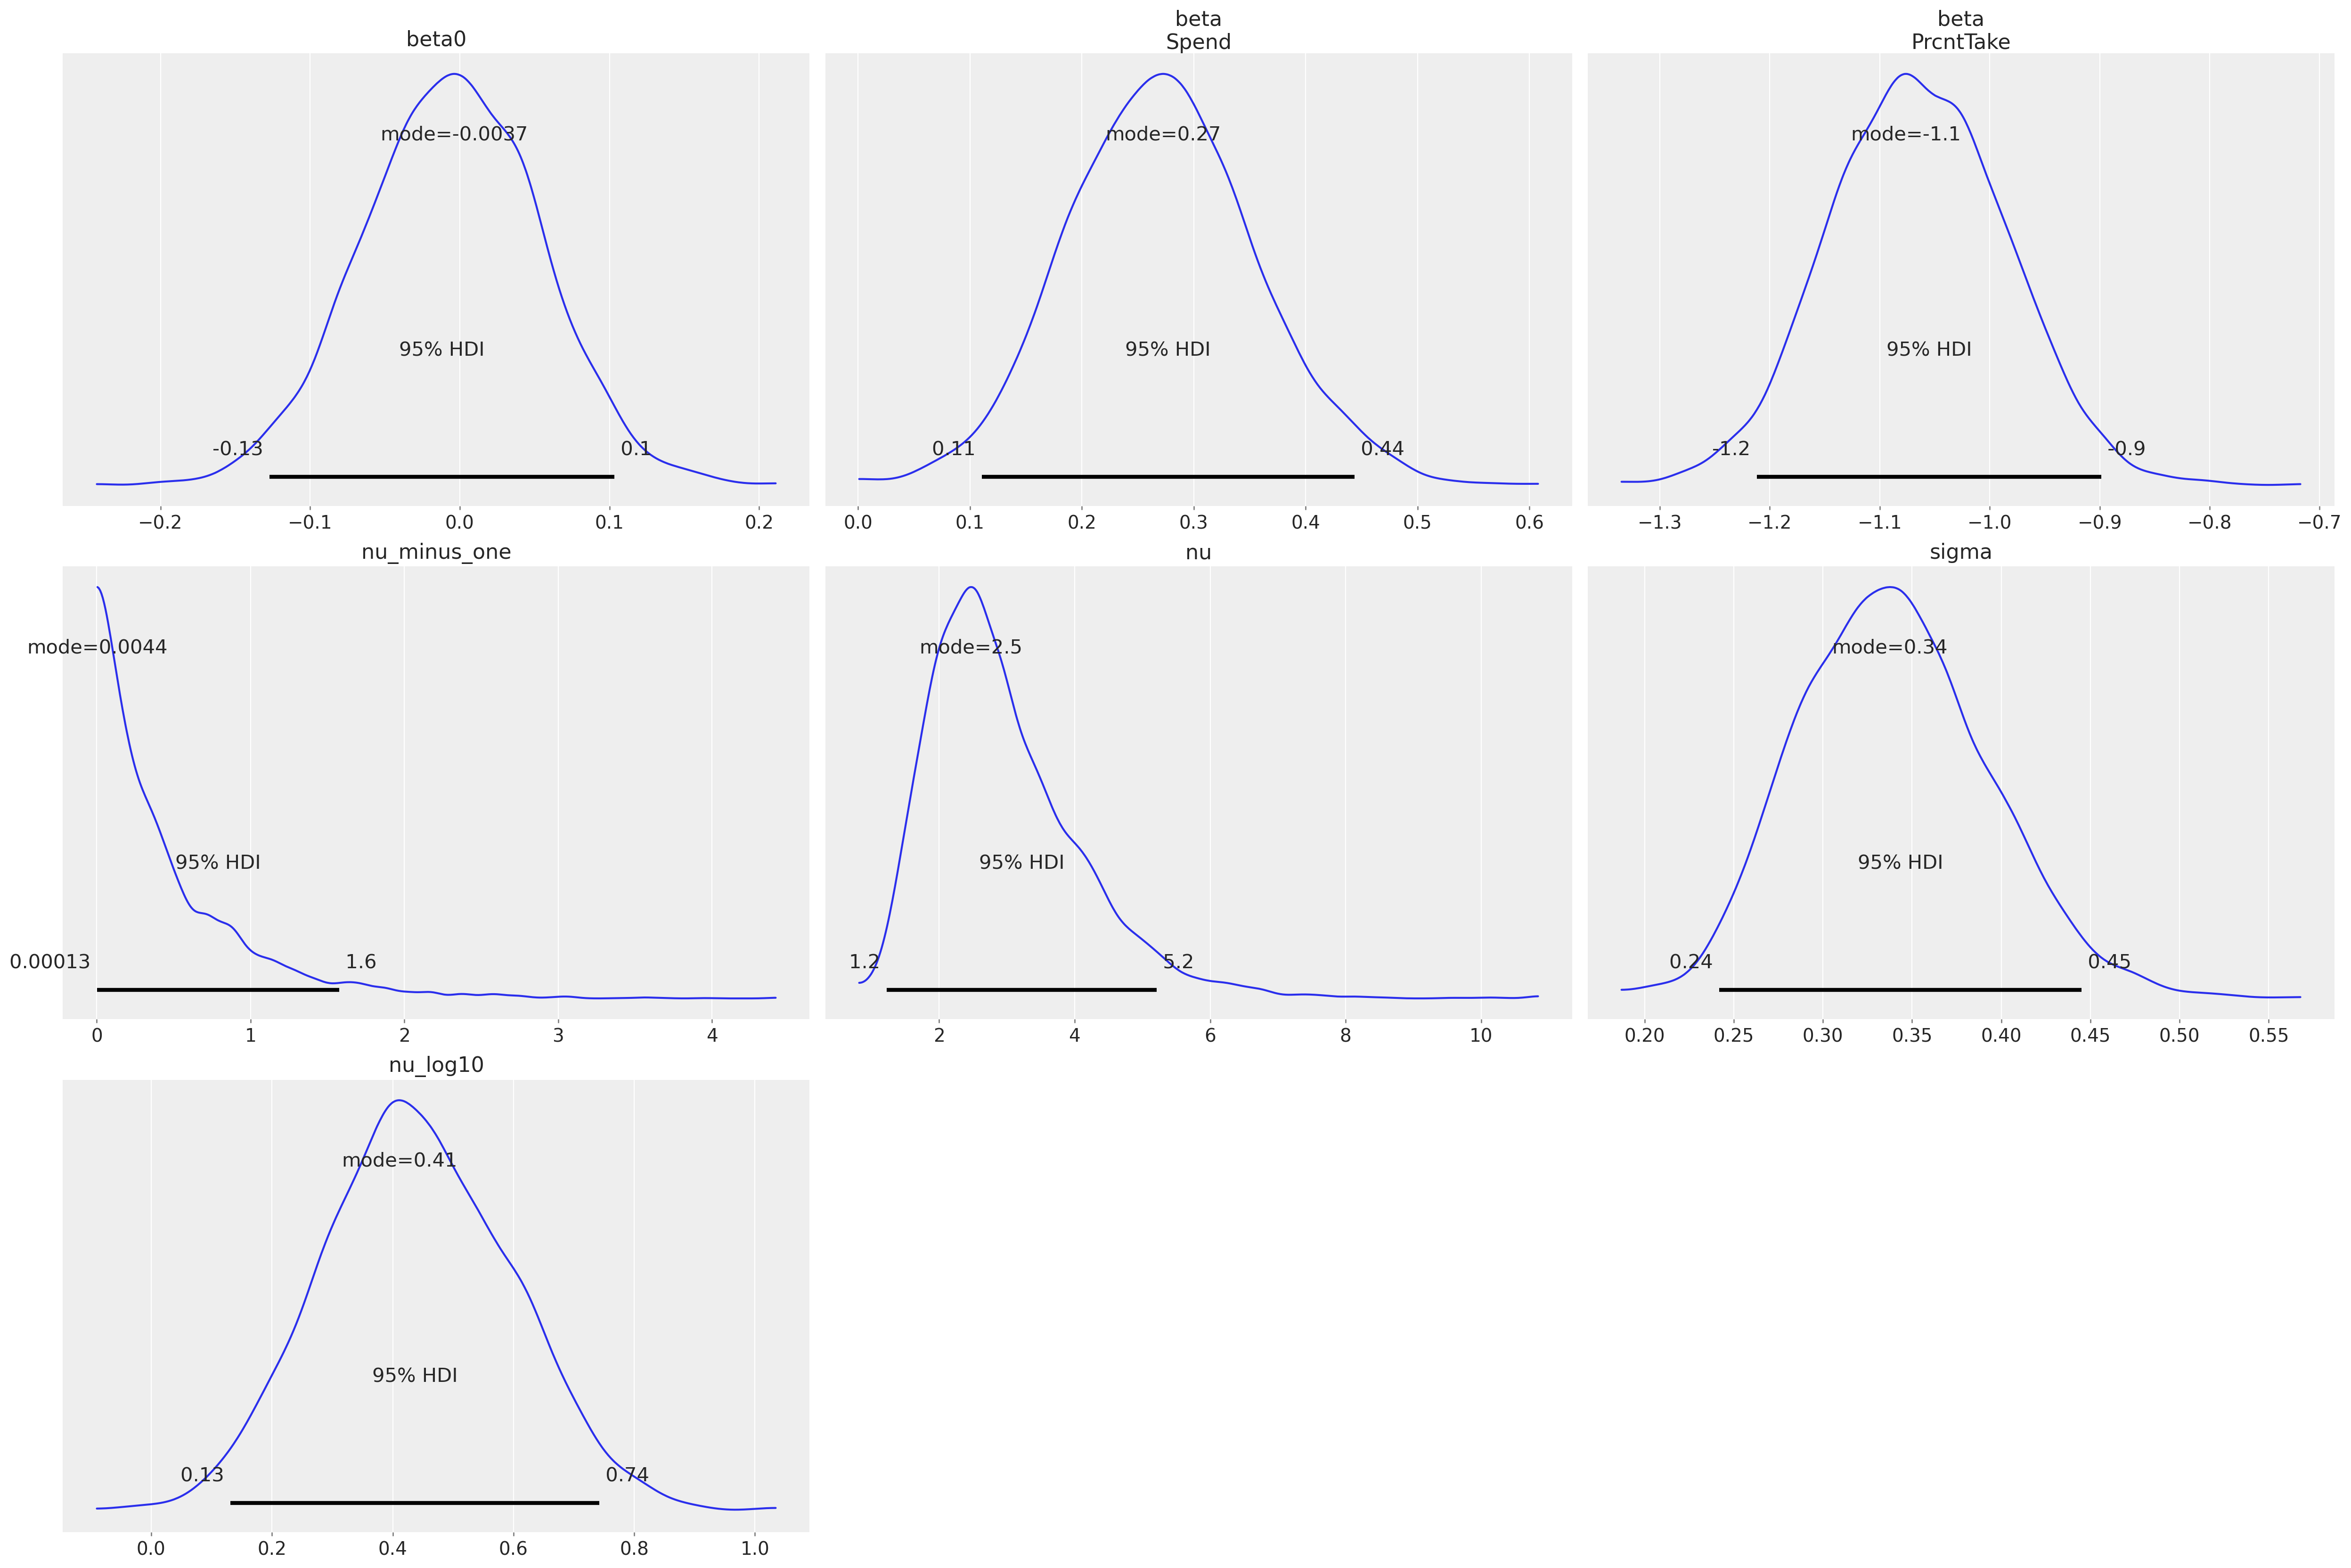

In [9]:
az.plot_posterior(idata, point_estimate="mode");

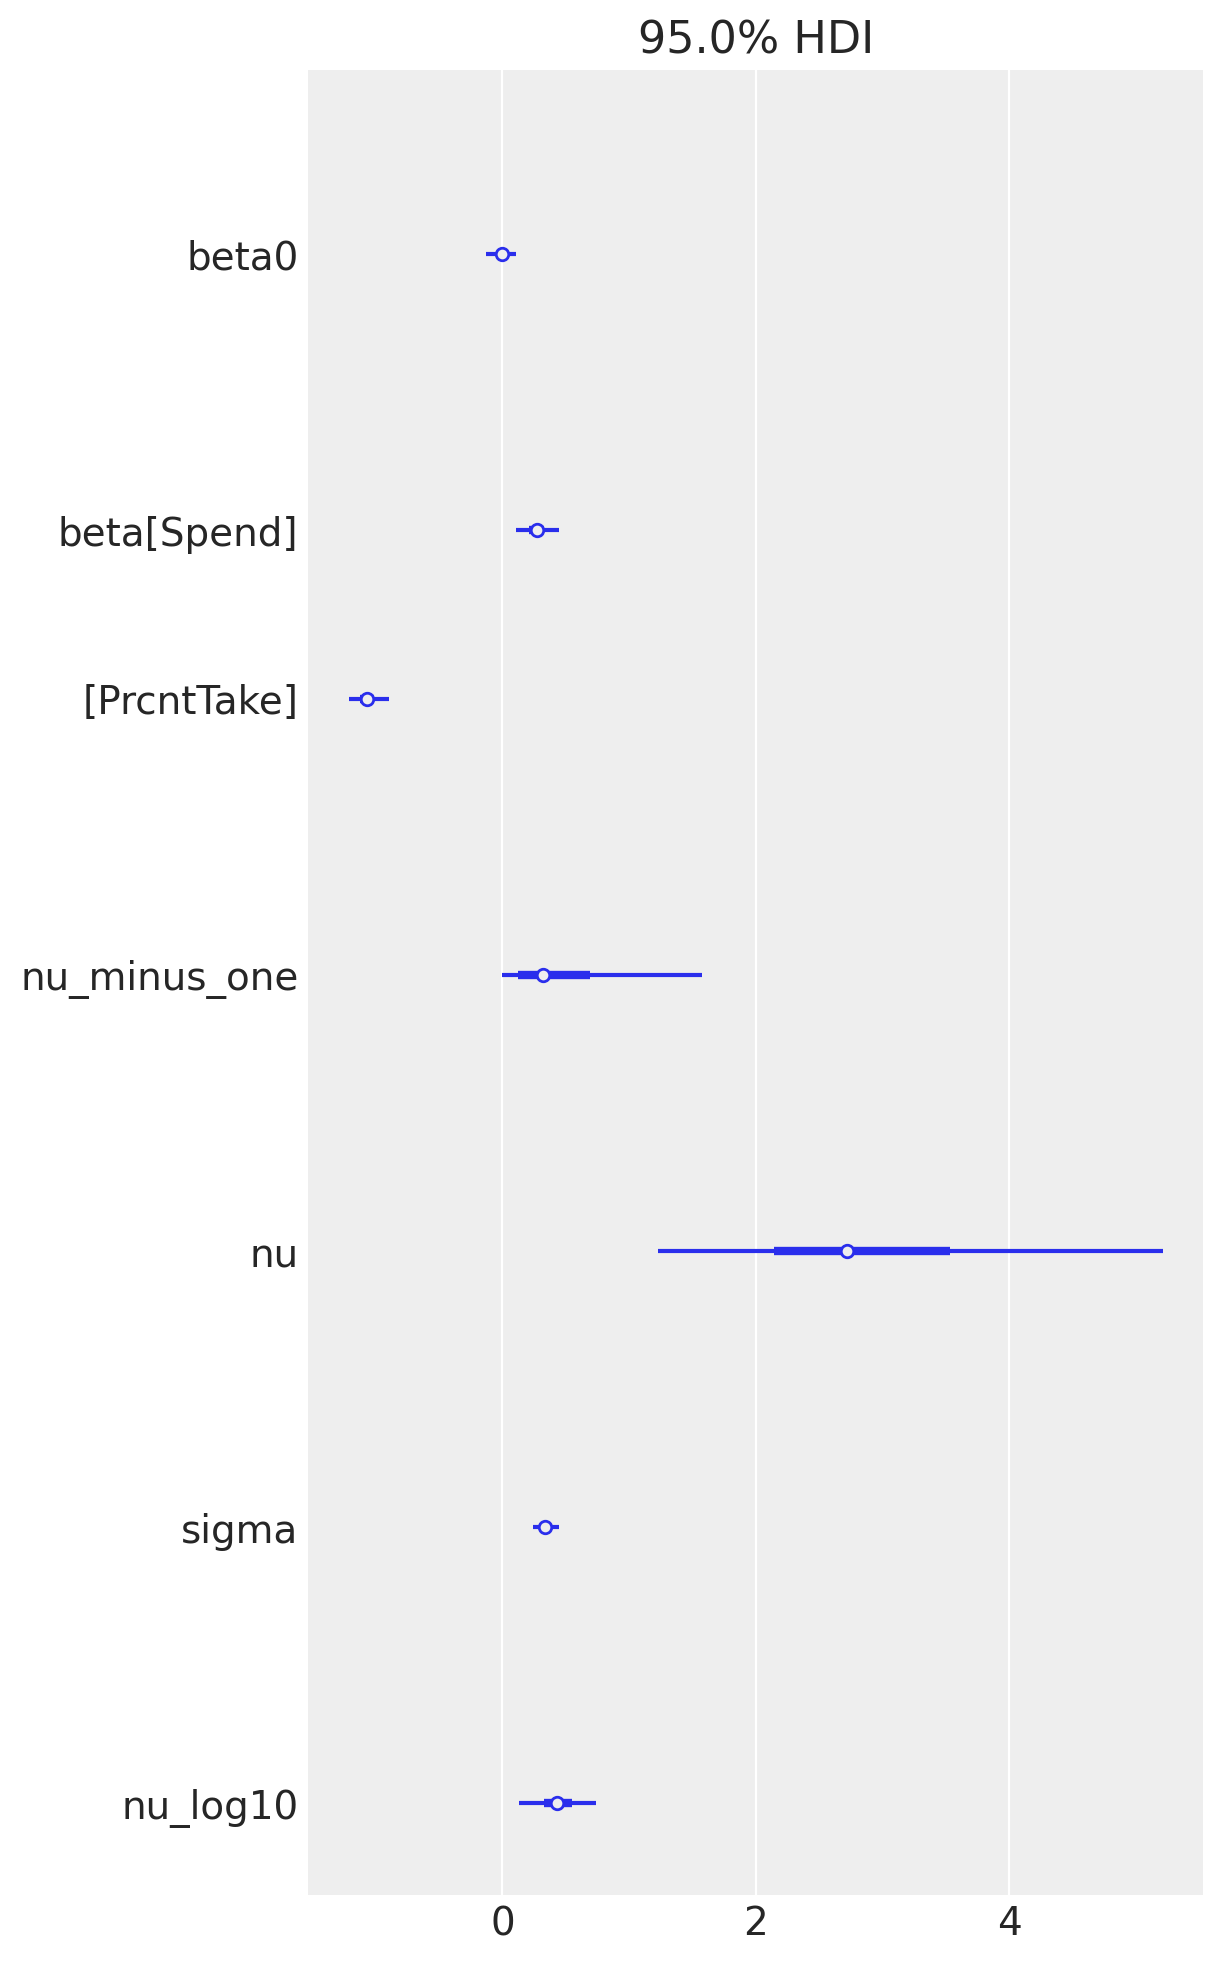

In [10]:
az.plot_forest(idata, combined=True);

In [11]:
# Get the dataset corresponding to a single "group" (see: https://arviz-devs.github.io/arviz/getting_started/WorkingWithInferenceData.html#add-a-new-variable)
post = idata.posterior

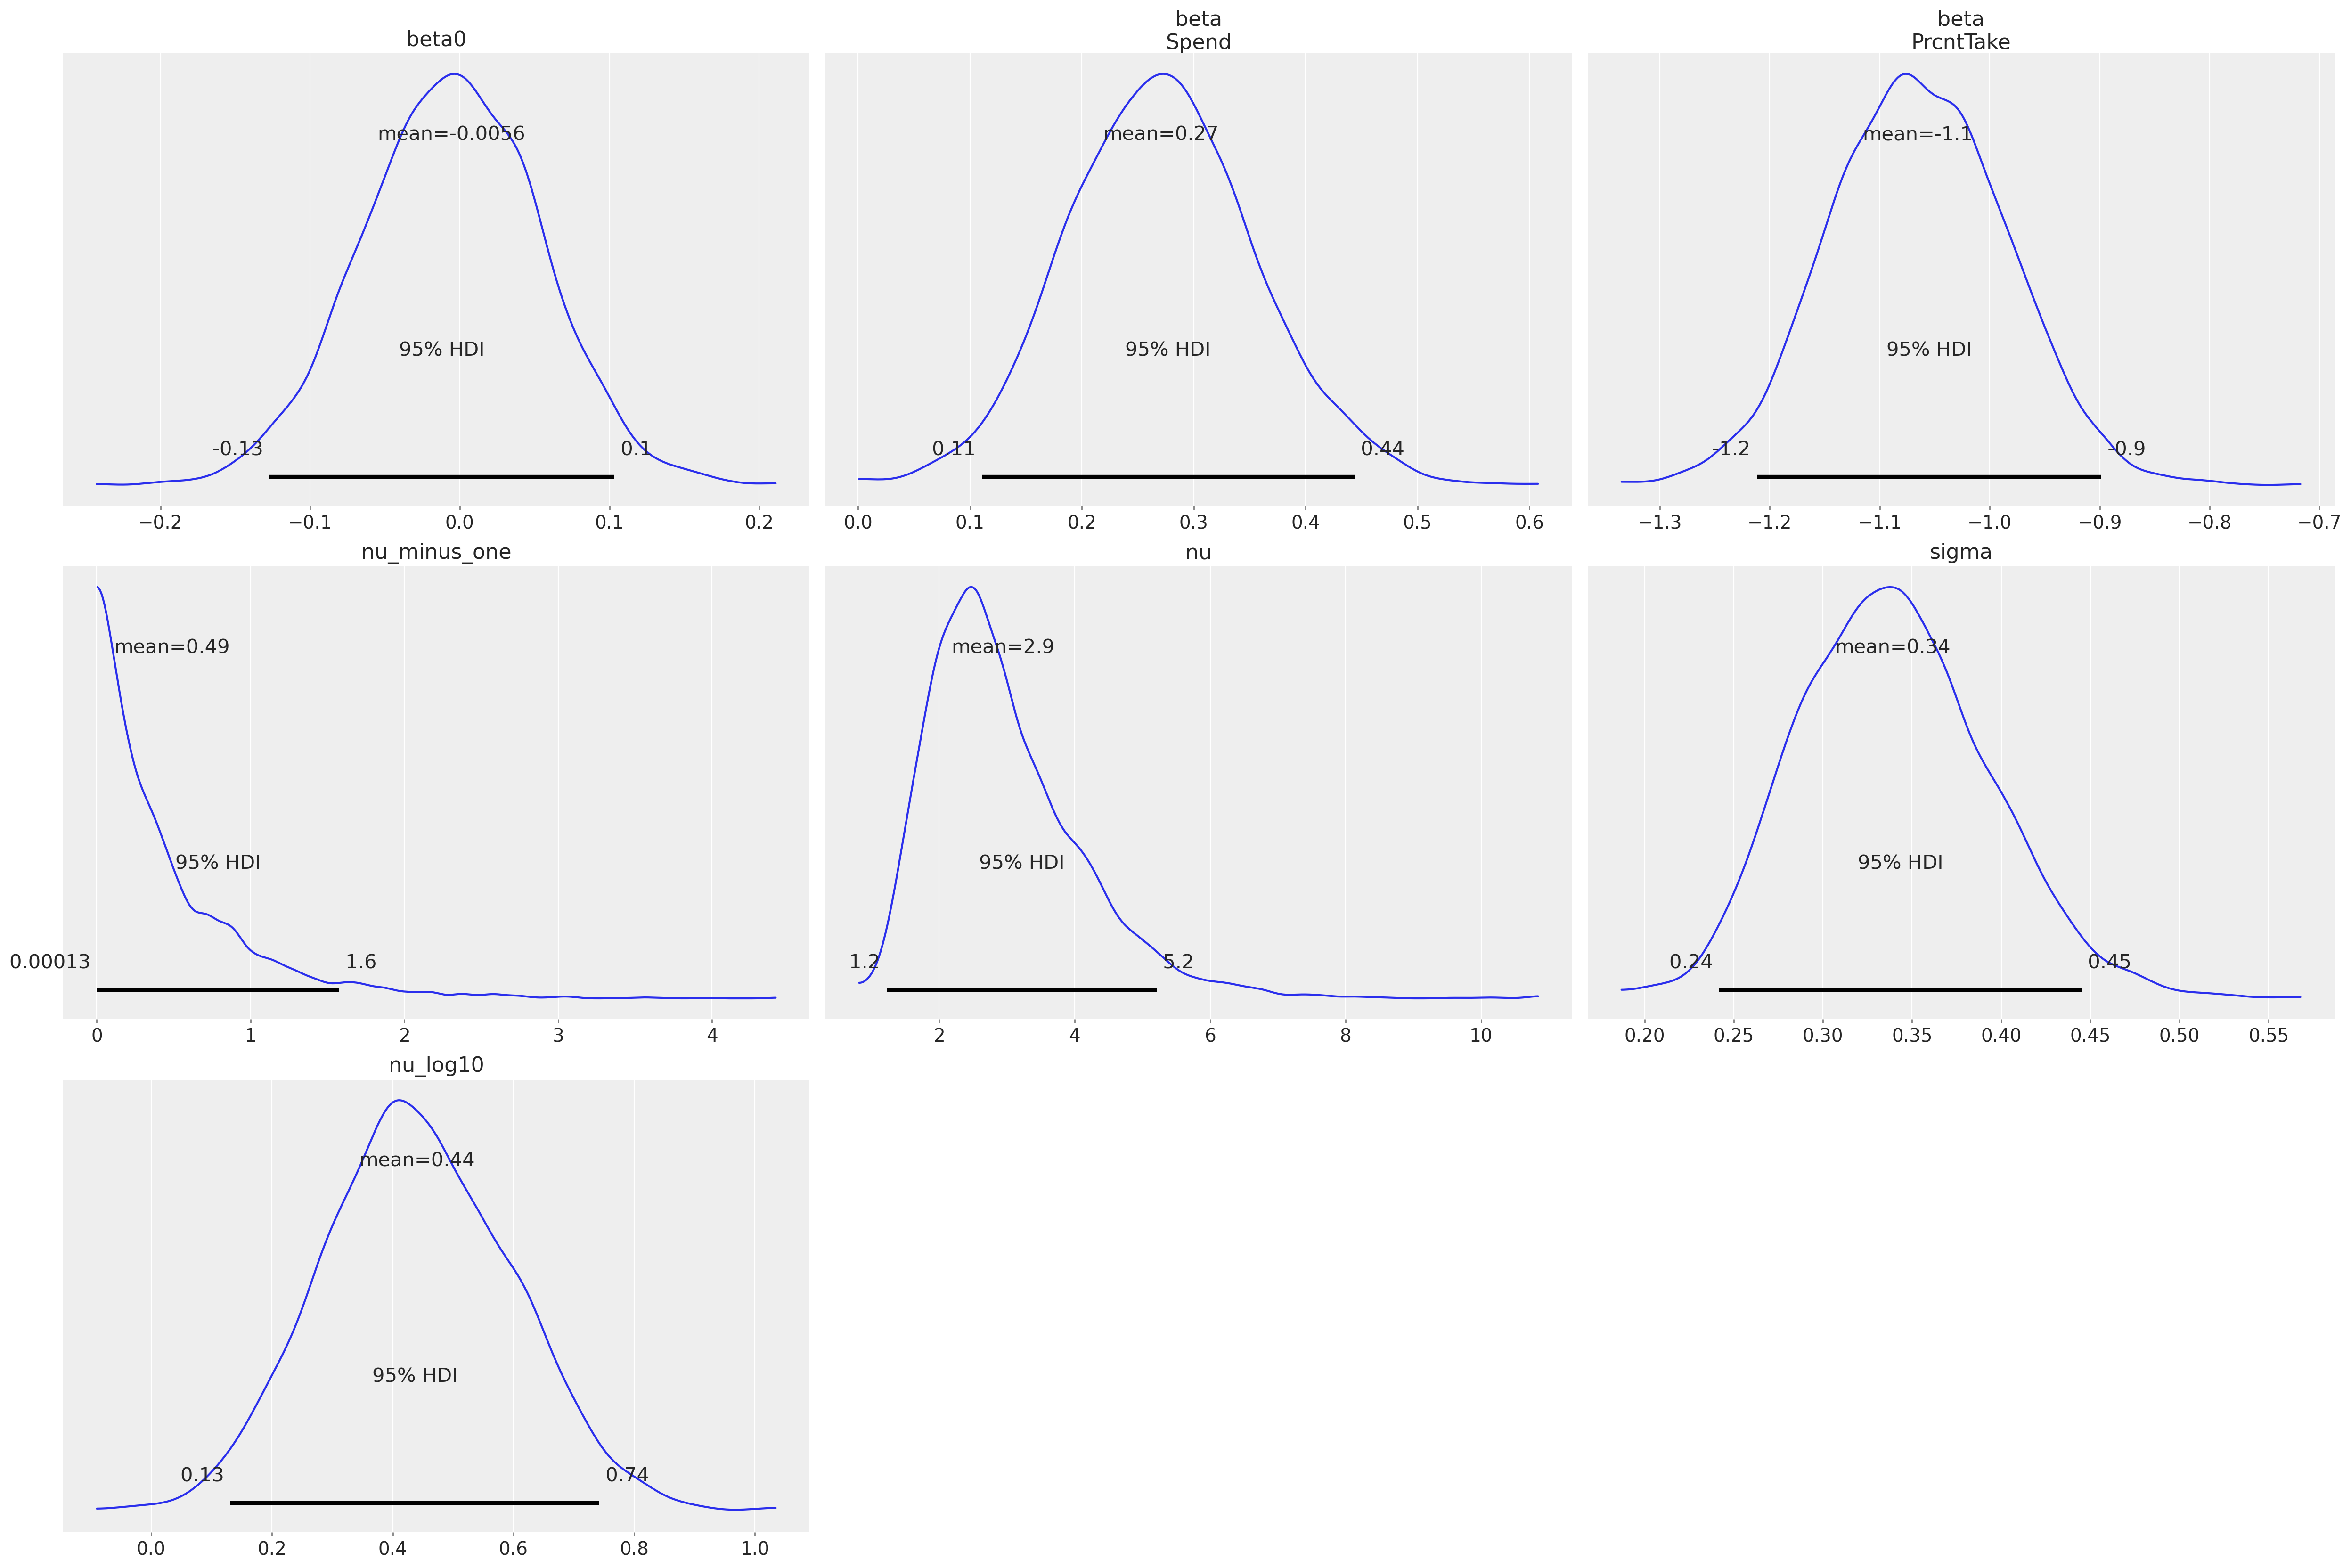

In [12]:
az.plot_posterior(post);

In [13]:
# import xarray as xr
# post["dummy"] = xr.DataArray(np.random.standard_normal((4, 1000)), dims=["chain", "draw"])
# post

In [14]:
post.dims

Frozen({'chain': 4, 'draw': 1000, 'predictors': 2})

In [15]:
stacked = az.extract(post)
stacked

<xarray.Dataset>
Dimensions:       (sample: 4000, predictors: 2)
Coordinates:
  * predictors    (predictors) <U9 'Spend' 'PrcntTake'
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    beta0         (sample) float64 0.03718 0.001266 ... 0.04217 -0.01607
    beta          (predictors, sample) float64 0.2544 0.3161 ... -1.122 -1.104
    nu_minus_one  (sample) float64 0.8509 0.9528 0.03856 ... 0.8944 0.5013
    nu            (sample) float64 2.679 2.325 3.01 1.622 ... 6.414 2.22 2.749
    sigma         (sample) float64 0.3449 0.3455 0.3476 ... 0.4112 0.3817 0.4013
    nu_log10      (sample) float64 0.428 0.3664 0.4785 ... 0.8071 0.3463 0.4392
Attributes:
    created_at:                 2022-11-07T19:42:57.716107
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              20.336146354675293
    tuning_steps:               1000

In [16]:
type(stacked["beta"])
stacked["beta"].shape

(2, 4000)

In [17]:
stacked["beta0_raw"], stacked["beta1_raw"], stacked["sigma_raw"] = bst.unstandardize_multiple_linreg_parameters(stacked["beta0"], stacked["beta"], mu_X, mu_y, stacked["sigma"], sigma_X, sigma_y)

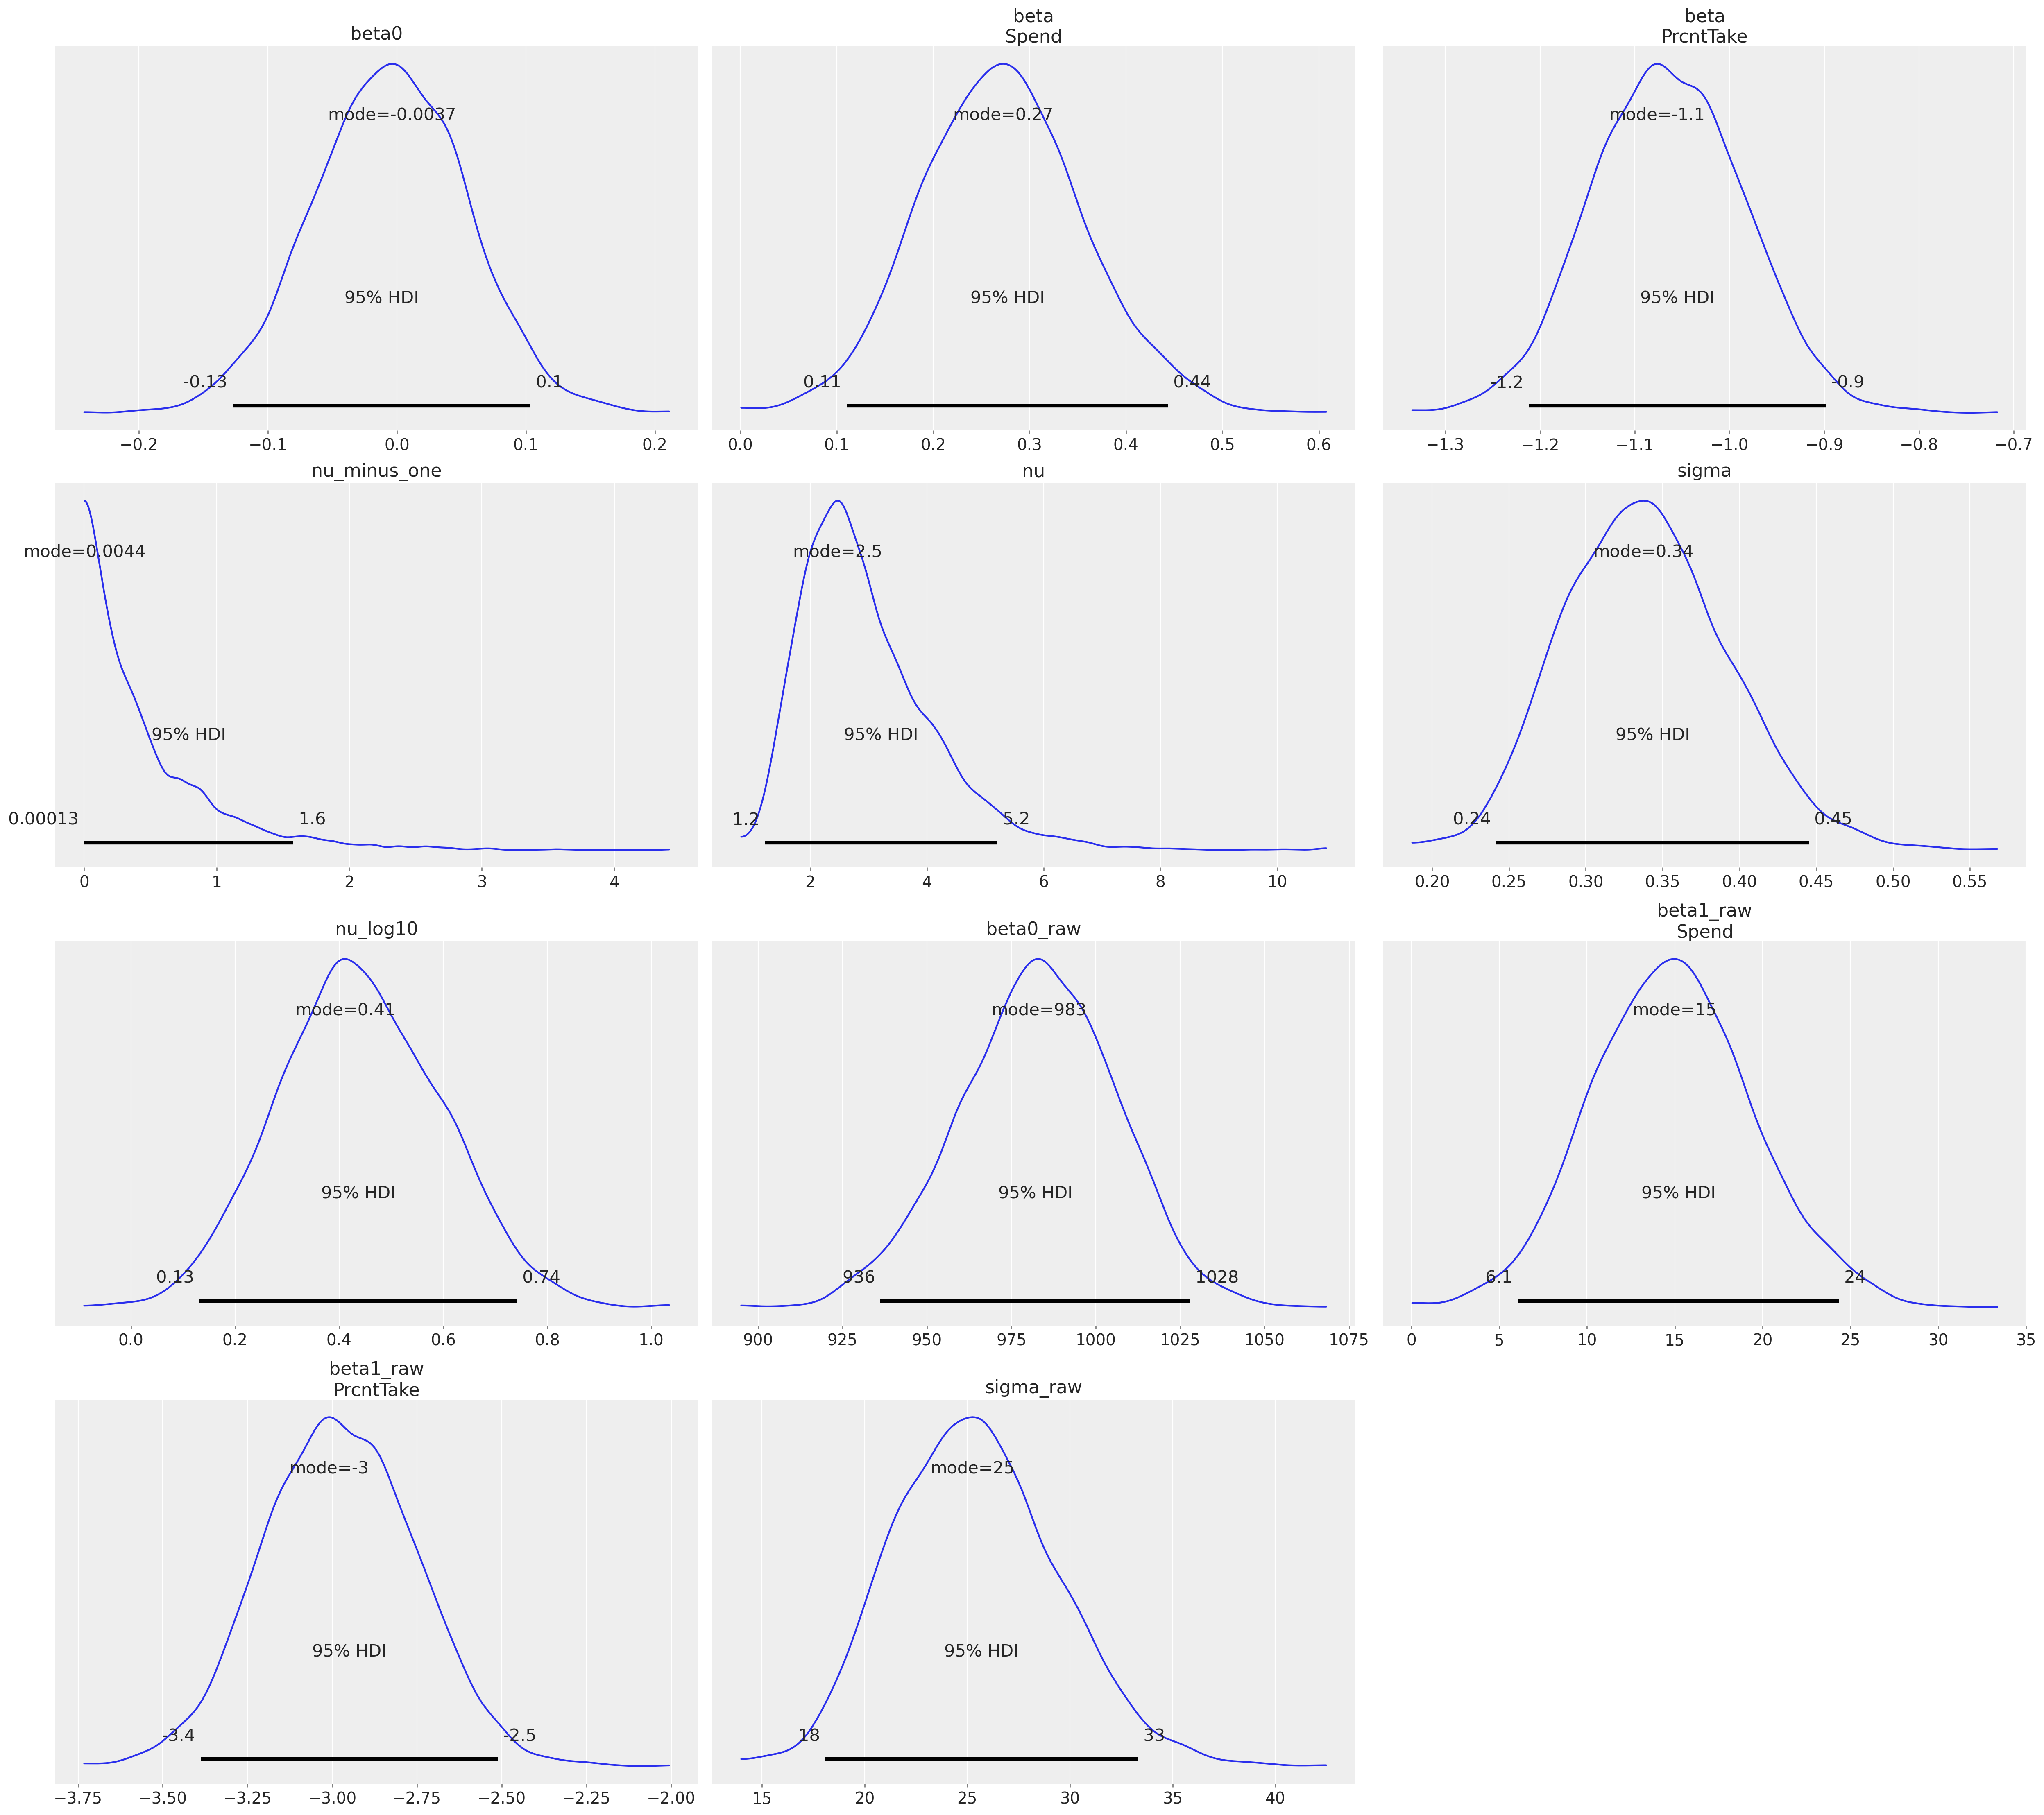

In [18]:
az.plot_posterior(stacked, combine_dims={"sample"}, point_estimate="mode");

In [19]:
unstacked = stacked.unstack()
# unstacked

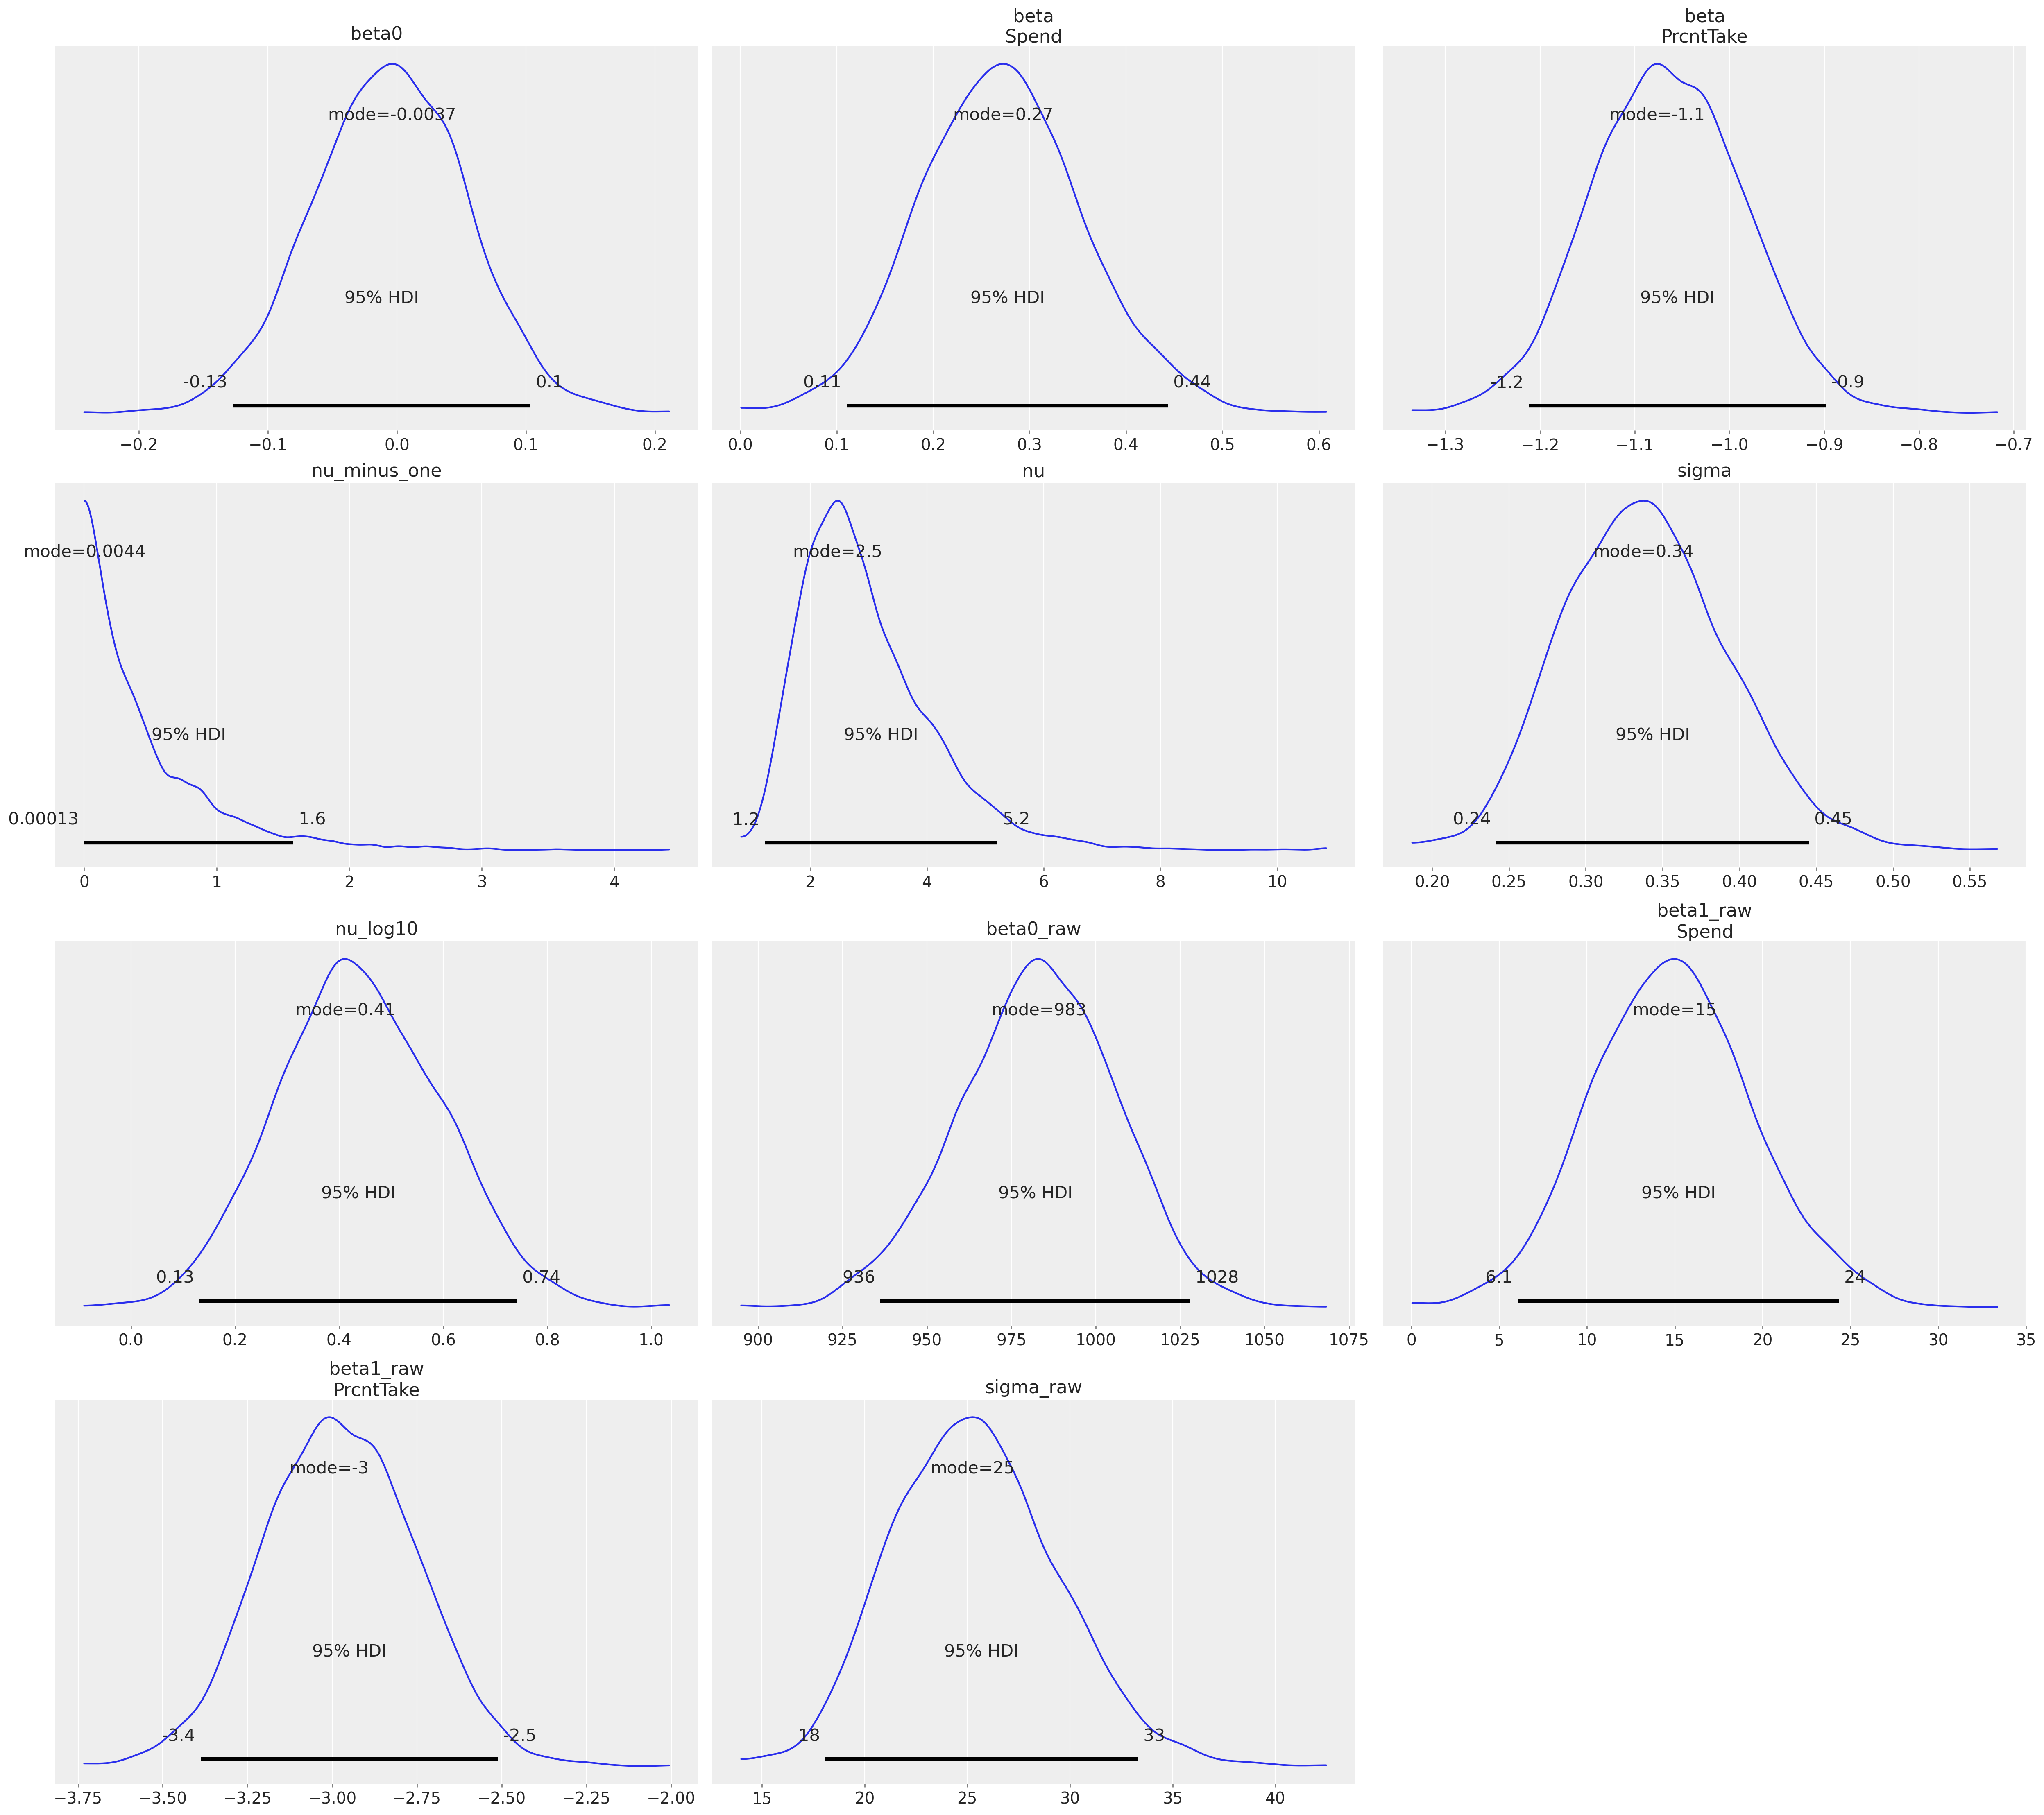

In [20]:
az.plot_posterior(unstacked, point_estimate="mode");

In [21]:
stacked

<xarray.Dataset>
Dimensions:       (predictors: 2, sample: 4000)
Coordinates:
  * predictors    (predictors) <U9 'Spend' 'PrcntTake'
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    beta0         (sample) float64 0.03718 0.001266 ... 0.04217 -0.01607
    beta          (predictors, sample) float64 0.2544 0.3161 ... -1.122 -1.104
    nu_minus_one  (sample) float64 0.8509 0.9528 0.03856 ... 0.8944 0.5013
    nu            (sample) float64 2.679 2.325 3.01 1.622 ... 6.414 2.22 2.749
    sigma         (sample) float64 0.3449 0.3455 0.3476 ... 0.4112 0.3817 0.4013
    nu_log10      (sample) float64 0.428 0.3664 0.4785 ... 0.8071 0.3463 0.4392
    beta0_raw     (sample) float64 995.7 965.0 1e+03 ... 984.9 989.4 975.0
    beta1_raw     (sample, predictors) float64 13.97 -3.105 ... 16.67 -3.086
    sigma_raw     (sample) float64 25.81 25.85 26.01 27.06 ... 30.77 28.56 30.03
Attributes:
    created_at:                 2022-11-07T19:42:57.716107
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              20.336146354675293
    tuning_steps:               1000

### Multiplicative interaction

In [28]:
X2 = X.assign(SpendXPrcnt=lambda x: x.Spend * x.PrcntTake)
X2.head()

Spend  PrcntTake  SpendXPrcnt
0  4.405          8       35.240
1  8.963         47      421.261
2  4.778         27      129.006
3  4.459          6       26.754
4  4.992         45      224.640

In [33]:
_, mu_X2, sigma_X2 = bst.standardize(X2)
_, mu_y2, sigma_y2 = bst.standardize(y)

In [26]:
model2, idata2 = bst.multiple_linear_regression(X_new, y, n_draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta, nu_minus_one, nu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 41 seconds.


In [30]:
post2 = idata2.posterior

In [31]:
stacked2 = az.extract(post2)
stacked2

<xarray.Dataset>
Dimensions:       (sample: 12000, predictors: 3)
Coordinates:
  * predictors    (predictors) <U11 'Spend' 'PrcntTake' 'SpendXPrcnt'
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw          (sample) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    beta0         (sample) float64 -0.07013 -0.117 ... -0.01179 -0.04663
    beta          (predictors, sample) float64 -0.01751 0.09393 ... 0.1849 1.048
    nu_minus_one  (sample) float64 0.4222 0.4699 0.4897 ... 0.3434 0.007597
    nu            (sample) float64 3.313 3.173 2.125 1.632 ... 2.845 2.236 2.504
    sigma         (sample) float64 0.3121 0.295 0.3613 ... 0.391 0.3996 0.3352
    nu_log10      (sample) float64 0.5202 0.5015 0.3273 ... 0.454 0.3494 0.3986
Attributes:
    created_at:                 2022-11-07T19:46:44.927860
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              40.52746295928955
    tuning_steps:               1000

In [34]:
stacked2["beta0_raw"], stacked2["beta_raw"], stacked2["sigma_raw"] = bst.unstandardize_multiple_linreg_parameters(
                                                                            stacked2["beta0"], stacked2["beta"], 
                                                                            mu_X2, mu_y, stacked2["sigma"], sigma_X2, 
                                                                            sigma_y)

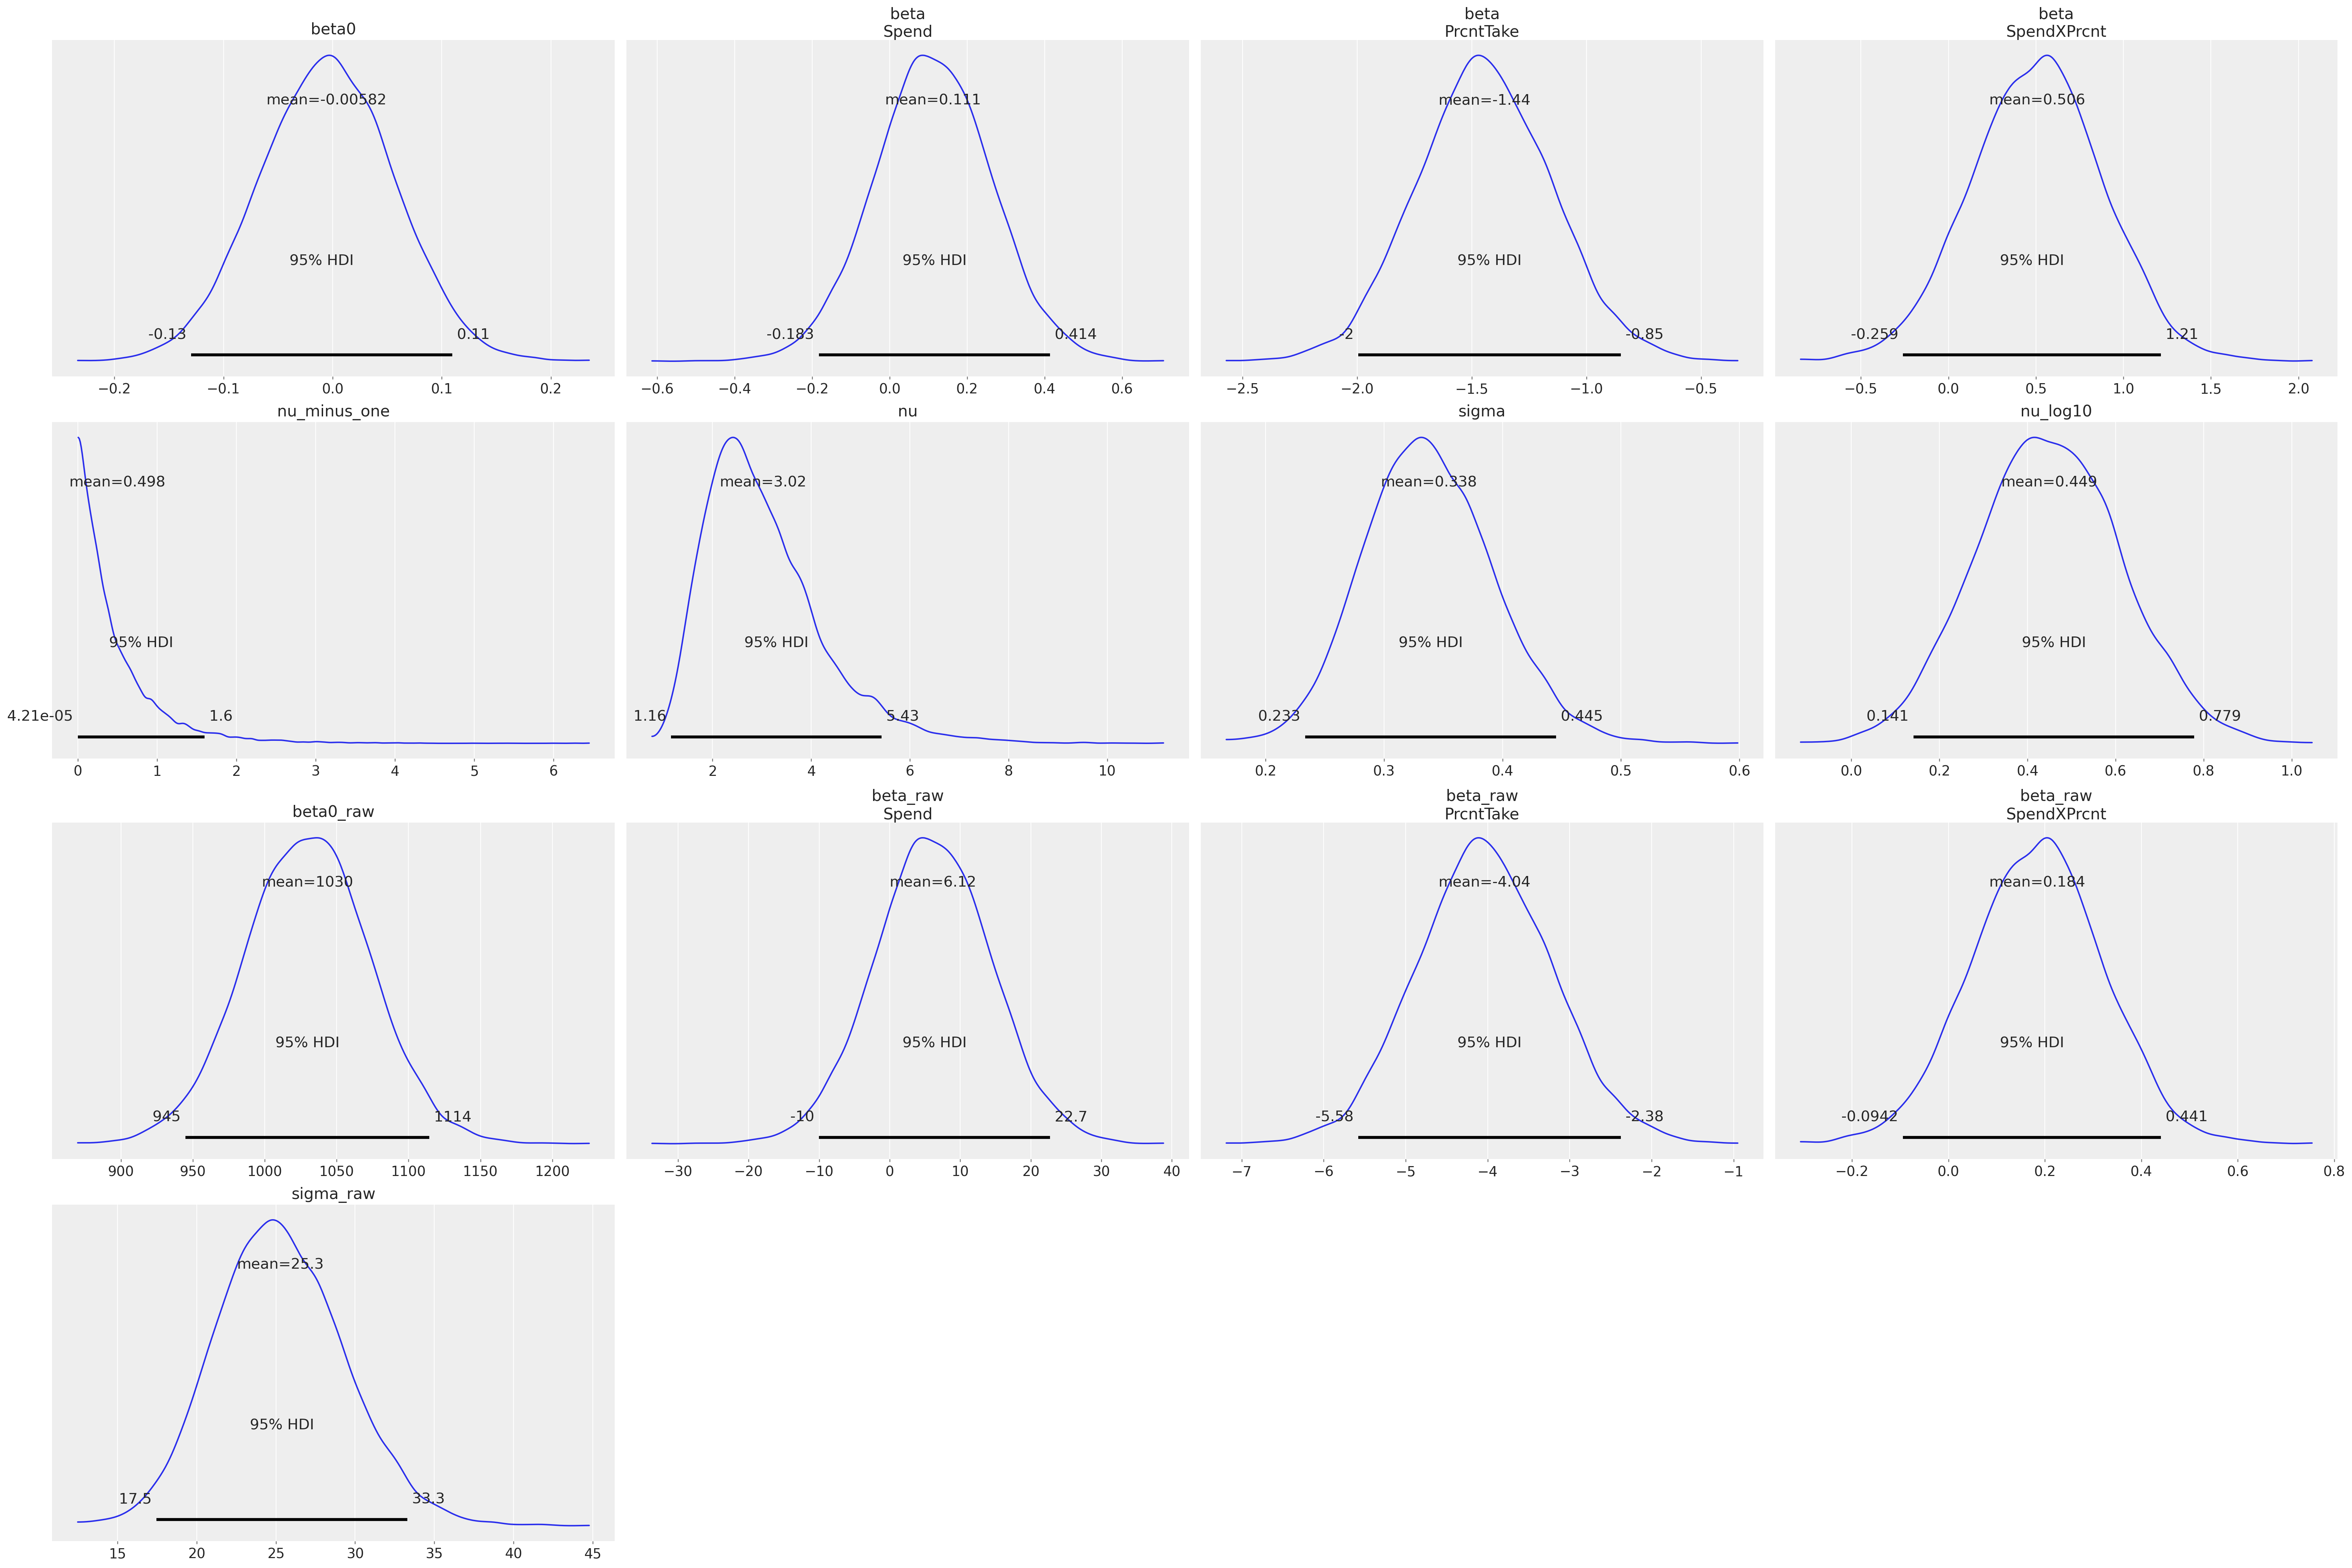

In [36]:
az.plot_posterior(stacked2, combine_dims={"sample"}, round_to=3);